In [2]:
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Preprocessing

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import random
import math
import time
from sklearn.model_selection import GridSearchCV


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Parts of this code are modified from the tutorial "Deep Learning with Pytorch: A 60 Minute Blitz" that can be found here: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html


In [7]:
transform_mnist = transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

transform_cifar = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
#create datasets for CIFAR10
train_c10_full= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)
test_c10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_cifar)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
#create datasets for MNIST
train_mnist_full = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_mnist)
test_mnist = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform_mnist)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
#create datasets for fashion MNIST
train_fmnist_full = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform_mnist)
test_fmnist = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform_mnist)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [11]:
#this code generates a training set and validation set from an
#input dataset and input minibatch size, ex:
#train_loader, validation_loader = function(train_c10_full, 32, 0.8, 0.2)

# p between 0 and 1, percent of data in tr_loader, q into validationloader
def train_val_split(train_data, minibatch_size, p, q):
    idx_range = list(range(0,len(train_data)))
    random.shuffle(idx_range)
    
    p_idx = int(p * len(idx_range))
    pq_idx = int((p+q) * len(idx_range))
    #middle = len(idx_range)//2
    tr_idx = idx_range[:p_idx]
    val_idx = idx_range[p_idx:pq_idx]
    
    train_subset = torch.utils.data.Subset(train_data, tr_idx)
    val_subset = torch.utils.data.Subset(train_data, val_idx)
    
    tr_loader = torch.utils.data.DataLoader(train_subset, batch_size=minibatch_size,
                                          shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=minibatch_size,
                                          shuffle=True, num_workers=2)
    return tr_loader, val_loader


In [12]:
#CIFAR10 dataloaders
train_c10_loader, val_c10_loader = train_val_split(train_c10_full, 32, 0.8, 0.2)


train_c10_mini, val_c10_mini = train_val_split(train_c10_full, 32, 0.05, 0.05)


test_c10_loader = torch.utils.data.DataLoader(test_c10, batch_size=32,
                                         shuffle=False, num_workers=2)


#MNIST dataloaders
train_mnist_loader,  val_mnist_loader = train_val_split(train_mnist_full, 32, 0.8, 0.2)

test_mnist_loader = torch.utils.data.DataLoader(test_mnist, batch_size=32,
                                         shuffle=False, num_workers=2)

#Fashion-MNIST dataloaders
train_fmnist_loader,  val_fmnist_loader = train_val_split(train_fmnist_full, 32, 0.8, 0.2)

test_fmnist_loader = torch.utils.data.DataLoader(test_fmnist, batch_size=32,
                                         shuffle=False, num_workers=2)

c10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
mnist_classes = ('0','1','2','3','4','5','6','7','8','9')

fmnist_classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

In [13]:
# print(train_fmnist_full)


# Display Functions

In [14]:
#un-normalize and display an imaage from a dataset
def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


In [15]:
#Adapted from google's tutorial
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
#show_sample will display the first minibatch of dataloader dl
#with the first 4 images labeled according to dl_classes
def show_samples(dl, dl_classes):

    # get some random training images
    dataiter = iter(dl)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % dl_classes[labels[j]] for j in range(4)))


In [17]:
#show_samples(test_fmnist_loader, fmnist_classes)
#show_samples(test_c10_loader, c10_classes)

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Network Architectures

In [19]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
class c10Net(nn.Module):
    def __init__(self):
        super(c10Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
#Drops 1/4 of the fully connected layers each iteration
class c10Net_dropout25(nn.Module):
    def __init__(self):
        super(c10Net_dropout25, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(0.25)



    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [22]:
#Drops 1/4 of the fully connected layers each iteration
class c10Net_dropout50(nn.Module):
    def __init__(self):
        super(c10Net_dropout50, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(0.50)



    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [23]:
class c10Net_2x_depth(nn.Module):
    def __init__(self):
        super(c10Net_2x_depth, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 6, 5, padding = 1)
        self.conv3 = nn.Conv2d(6, 16, 5, padding = 1)
        self.conv4 = nn.Conv2d(16, 16, 5, padding = 1)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 84)
        self.fc5 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 16 * 5 * 5)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = self.fc5(x)
        return x

In [24]:
class c10Net_2x_width(nn.Module):
    def __init__(self):
        super(c10Net_2x_width, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 168)
        self.fc3 = nn.Linear(168, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
class c10Net_3x_width(nn.Module):
    def __init__(self):
        super(c10Net_3x_width, self).__init__()
        self.conv1 = nn.Conv2d(3, 18, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 48, 5)
        self.fc1 = nn.Linear(48 * 5 * 5, 360)
        self.fc2 = nn.Linear(360, 252)
        self.fc3 = nn.Linear(252, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 48 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
class c10Net_2x_width_depth(nn.Module):
    def __init__(self):
        super(c10Net_2x_width_depth, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 12, 5, padding = 1)
        self.conv3 = nn.Conv2d(12, 32, 5, padding = 1)
        self.conv4 = nn.Conv2d(32, 32, 5, padding = 1)

        self.fc1 = nn.Linear(32 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 240)
        self.fc3 = nn.Linear(240, 168)
        self.fc4 = nn.Linear(168, 168)
        self.fc5 = nn.Linear(168, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 32 * 5 * 5)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = self.fc5(x)
        return x

In [27]:
class c10Net_2x_width_depth_dropout(nn.Module):
    def __init__(self):
        super(c10Net_2x_width_depth_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 12, 5, padding = 1)
        self.conv3 = nn.Conv2d(12, 32, 5, padding = 1)
        self.conv4 = nn.Conv2d(32, 32, 5, padding = 1)

        self.fc1 = nn.Linear(32 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 240)
        self.fc3 = nn.Linear(240, 168)
        self.fc4 = nn.Linear(168, 168)
        self.fc5 = nn.Linear(168, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 32 * 5 * 5)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [28]:
class c10Net_log_softmax(nn.Module):
    def __init__(self):
        super(c10Net_softmax, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 0)
        return x

In [29]:
class c10Net_softmax(nn.Module):
    def __init__(self):
        super(c10Net_softmax, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim = 0)
        return x

# Training Loop

In [33]:
criterion = nn.NLLLoss()
criterion_softmax = nn.CrossEntropyLoss()

In [122]:
#compute the accuracy of net net identifying the classes of data in the dataloader dl
def compute_accuracy(net, dl):
    correct = 0
    total = 0
    net.to(device)
    net.eval()
    with torch.no_grad():
        for (images, labels) in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    net.train()
    return 100 * correct / total

In [123]:
#train net with a specified number of
def train_net_bounded(net, hyper, trainloader, validationloader, print_mode = False):
    (num_epochs, learning_rate, momentum) = hyper
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    train_loss_list = []
    val_loss_list = []
    train_start = time.time()

    net = net.to(device)
    
    # loop until the validation accuracy stagnates for 5 epochs
    for epoch in range(num_epochs):
        tot_train_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()


        
        # train_acc = compute_accuracy(net, trainloader)
        # val_acc = compute_accuracy(net, validationloader)
        
        tot_val_loss = 0.0
        with torch.no_grad():
            for (images, labels) in validationloader:
                images, labels = images.to(device), labels.to(device)
                predictions = net(images)
                batch_val_loss = criterion(predictions, labels)
                tot_val_loss += batch_val_loss.item() 



        avg_train_loss = tot_train_loss / len(trainloader)
        avg_val_loss = tot_val_loss / len(validationloader)
        current = time.time()
        
        if(print_mode):
            print('Epoch: %d Train Loss: %f Val Loss: %f Time: %ds' % \
                 (epoch,avg_train_loss,avg_val_loss, current-train_start))

        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        
    train_end = time.time()
    
    print('Finished Training')
    best_epoch = val_loss_list.index(min(val_loss_list)) + 1
    print('Best model at epoch: %d with validation loss of %f'  % (best_epoch, val_loss_list[best_epoch - 1]))
    return(train_loss_list, val_loss_list, train_end-train_start)

In [124]:
#a modification of the above, where we train until the validation accuracy stops improving.
#Will it work?
def train_net_unbounded(criterion, net, hyper, trainloader, validationloader,path, print_mode = False):
    (learning_rate, momentum) = hyper
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    train_loss_list = []
    val_loss_list = []
    train_start = time.time()

    net = net.to(device)
    
    best_val_loss = 100 #arbitrarily large number
    epoch = 0
    # loop until the validation accuracy stagnates for 5 epochs
    while (len(val_loss_list) < 15 or val_loss_list[epoch-1] < val_loss_list[epoch - 10]):
        tot_train_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()

        epoch+=1
        
        # train_acc = compute_accuracy(net, trainloader)
        # val_acc = compute_accuracy(net, validationloader)
        net.eval()
        tot_val_loss = 0.0
        with torch.no_grad():
            for (images, labels) in validationloader:
                images, labels = images.to(device), labels.to(device)
                predictions = net(images)
                batch_val_loss = criterion(predictions, labels)
                tot_val_loss += batch_val_loss 
        net.train()
        

        avg_train_loss = tot_train_loss / len(trainloader)
        avg_val_loss = tot_val_loss / len(validationloader)
        current = time.time()
        
        if (avg_val_loss < best_val_loss):
            best_val_loss = avg_val_loss
            torch.save(net.state_dict(), path)

        if(print_mode):
            print('Epoch: %d Train Loss: %f Val Loss: %f Time: %ds' % \
                 (epoch,avg_train_loss,avg_val_loss, current-train_start))

        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        
    train_end = time.time()
    
    print('Finished Training after %fs' % (train_end - train_start))
    best_epoch = val_loss_list.index(min(val_loss_list)) + 1
    print('Best model at epoch: %d with validation loss of %f'  % (best_epoch, val_loss_list[best_epoch - 1]))
    return(train_loss_list, val_loss_list, train_end-train_start)

In [54]:
#this code trains a sample network  

# net = c10Net()
# save_name = 'c10Net_opt.pth'
# hyper = (0.01,0.7) #(learning_rate, momentum)
# tr, val, t = train_net_unbounded(criterion_softmax, net, hyper, train_c10_loader, val_c10_loader, save_name, True)
# net.load_state_dict(torch.load(save_name))

Epoch: 1 Train Loss: 1.973940 Val Loss: 1.641863 Time: 14s
Epoch: 2 Train Loss: 1.520943 Val Loss: 1.411462 Time: 28s
Epoch: 3 Train Loss: 1.364211 Val Loss: 1.322509 Time: 42s
Epoch: 4 Train Loss: 1.258939 Val Loss: 1.228080 Time: 56s
Epoch: 5 Train Loss: 1.171082 Val Loss: 1.159990 Time: 69s
Epoch: 6 Train Loss: 1.100983 Val Loss: 1.131376 Time: 83s
Epoch: 7 Train Loss: 1.044042 Val Loss: 1.129581 Time: 97s
Epoch: 8 Train Loss: 0.991601 Val Loss: 1.083995 Time: 111s
Epoch: 9 Train Loss: 0.947649 Val Loss: 1.071577 Time: 125s
Epoch: 10 Train Loss: 0.902388 Val Loss: 1.061843 Time: 138s
Epoch: 11 Train Loss: 0.867136 Val Loss: 1.065265 Time: 152s
Epoch: 12 Train Loss: 0.828966 Val Loss: 1.089182 Time: 166s
Epoch: 13 Train Loss: 0.796331 Val Loss: 1.119165 Time: 180s
Epoch: 14 Train Loss: 0.759911 Val Loss: 1.138369 Time: 194s
Epoch: 15 Train Loss: 0.728280 Val Loss: 1.155931 Time: 207s
Finished Training after 207.964975s
Best model at epoch: 10 with validation loss of 1.061843


<All keys matched successfully>

#Grid Search


In [147]:
params = {
    'lr': [0.1, 0.01, 0.001],
    'm' : [0.7, 0.8, 0.9]
}
params_dummy = {
    'lr': [0.01],
    'm' : [0.7]
}

print(type(params))

<class 'dict'>


In [141]:
def grid_search_net(criterion, netClass, trainloader, validationloader, out_path, params):
    start = time.time()
    temp_path = "temp.pth"
    lrs, ms = params['lr'], params['m']
    best_val_loss, best_t, best_trList, best_valList, best_lr, best_m = 100, 0, [], [], 0, 0
    for lr in lrs:
        for m in ms:
            print('Trying Learning Rate %f and Momentum %f' % (lr,m))
            temp = netClass()
            trList, valList, t = train_net_unbounded(criterion, temp, (lr,m), trainloader, validationloader, temp_path, True)
            if min(valList) < best_val_loss:
                best_val_loss, best_t, best_trList, best_valList, best_lr, best_m = min(valList), t, trList, valList, lr, m
                temp.load_state_dict(torch.load(temp_path))
                torch.save(temp.state_dict(), out_path)
    end = time.time()
    print('Best Validation Loss: %f' % best_val_loss)
    print('Best Learning Rate: %f' % best_lr)
    print('Best Momentum: %f' % best_m)
    print('Total time elapsed %ds' % (end - start))
    return best_trList, best_valList, best_t, best_lr, best_m






In [146]:
#execute a grid search
netClass = c10Net_2x_width_depth_dropout
out = 'bigmodeldropout.pth'
tr, val, t, lr, m = grid_search_net(criterion_softmax, netClass, train_c10_loader, val_c10_loader, out, params_dummy)
net = netClass()
net.load_state_dict(torch.load(out))

Trying Learning Rate 0.001000 and Momentum 0.700000
Epoch: 1 Train Loss: 2.303395 Val Loss: 2.302715 Time: 16s
Epoch: 2 Train Loss: 2.302775 Val Loss: 2.302653 Time: 32s


KeyboardInterrupt: ignored

In [ ]:
# PATH = './cifar_net.pth'
# PATH_MNIST = './mnist_net.pth'
# torch.save(net.state_dict(), PATH_MNIST)

In [108]:
# net = MNISTNet()
# net.load_state_dict(torch.load('fMNISTNet_opt.pth'))

<All keys matched successfully>

# Model Evaluation

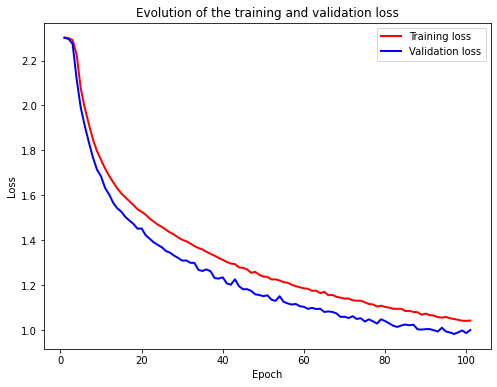

Elapsed: 1390s Learning Rate: 0.001000 Momentum: 0.700000


In [143]:
def plot_losses(train_history, val_history, t, hyper):

    colors = ['r','b']
    
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()
    (lr, m) = hyper
    print('Elapsed: %ds Learning Rate: %f Momentum: %f'% (t, lr, m))

#plot_losses(tr, val, t, hyper)
plot_losses(tr, val, t, (lr, m))


Much of this section is adapted directly from a Google Colab tutorial
The tutorial can be found here: https://colab.research.google.com/drive/1B5KQvPySqYEa6XicRHdOwgv8fN1BrCgQ


In [ ]:
#load in a dataset that was saved earlier


In [144]:
#ADAPTED FROM GOOGLE COLAB PYTORCH TUTORIAL
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def compute_accuracy(net, train, val, test):
    dataset_accuracy(net, train, "training")
    dataset_accuracy(net, val, "validation")
    dataset_accuracy(net, test, "testing")

In [145]:
compute_accuracy(net, train_c10_loader, val_c10_loader, test_c10_loader)

Accuracy of the network on the 40000 training images: 63.54 %
Accuracy of the network on the 10000 validation images: 60.11 %
Accuracy of the network on the 10000 testing images: 59.84 %


In [93]:
#FROM GOOGLE COLAB TUTORIAL
def accuracy_per_class(net, classes, testloader):
    net = net.to(device)
    # (real, predicted)
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=np.int64)

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(16):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(len(classes)):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net, mnist_classes, test_mnist_loader)

Class      Accuracy (%)
0            99.79   
1            99.83   
2            98.90   
3            98.44   
4            99.02   
5            99.07   
6            98.26   
7            99.42   
8            98.08   
9            97.87   


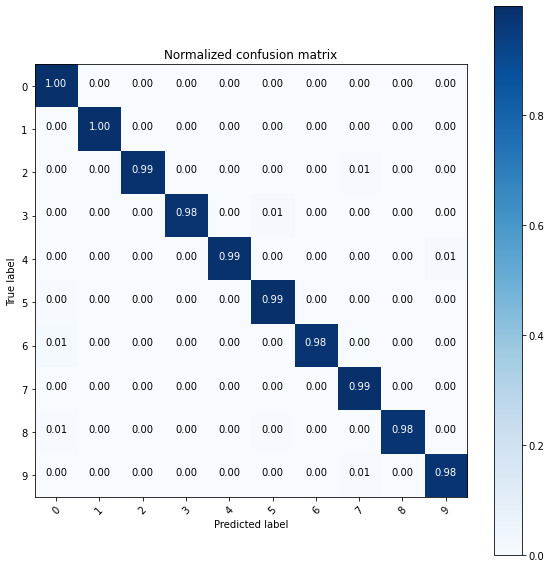

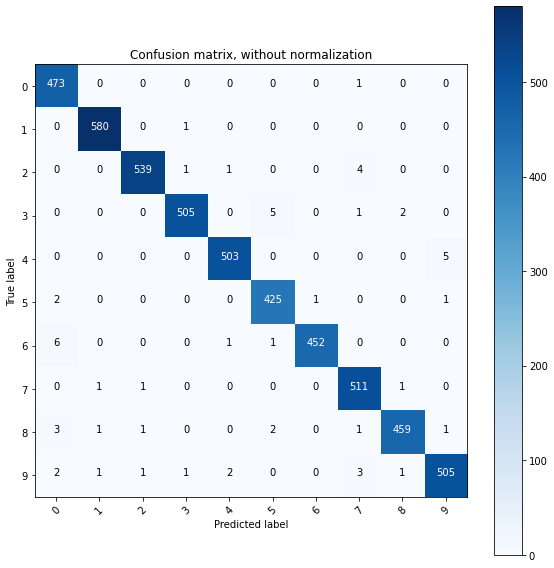

In [95]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, mnist_classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, mnist_classes,
                      title='Confusion matrix, without normalization')